In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt
from data_generation import ExecutePairTrading, generate_training_data
random.seed(23)
import cProfile
import pstats
import pickle
import plotly.express as px
from time import time
import warnings
warnings.filterwarnings('ignore')

import os
if not os.path.exists('Generated'):
    os.makedirs('Generated')

def chunker(seq, size):
    # split a list into chunks
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

/tmp/ipykernel_19533/3474267291.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# data = pd.read_csv('../sp500_full_20181231_to_20231229.csv')
data = pd.read_csv('../sp500_full_19991201_to_20231231.csv')
value_count_tb = data[['Ticker']].groupby('Ticker').size().reset_index()
value_count_tb.columns = ['Ticker', 'Count']
stock_to_keep = value_count_tb['Ticker'][value_count_tb.Count==value_count_tb.Count.max()]
data = data[data.Ticker.isin(stock_to_keep)]

# Generate for all pairs

In [3]:
tickers = list(set(data.Ticker.values))
combinations = list(itertools.combinations(tickers, 2))
len(combinations)
batches = list(chunker(combinations, 1000))

In [4]:
len(data)

2169122

In [5]:
# This code allows you to reimport the module if changes happen in data_generation.py
from importlib import reload
import data_generation
reload(data_generation)
from data_generation import ExecutePairTrading, generate_training_data

i = 0
for batch in batches:
    start_ts=time()
    print(f'Getting {i+1}th out of {len(batches)} batches')
    max_pairs = 1
    features_tb, labels_tb = generate_training_data(
        data=data,
        moving_average=60,
        training_len=300,
        test_len=60,
        entry_signal=2,
        exit_signal=0.5,
        calculate_label=True,
        verbose=False,
        max_combinations=max_pairs,
        combinations=batch
    )
    combined = pd.merge(features_tb, labels_tb, how='left', on=['Date', 'Ticker_P1','Ticker_P2']).reset_index(drop=True)
    combined = combined[combined.pnls.notnull()].reset_index(drop=True)
    combined.to_csv(f'./Generated/pair_features_{i+1}_pairs{max_pairs}_300_120.csv', index=False)
    end_ts = time()
    print(f"Took {end_ts - start_ts} seconds")
    i+=1
    break
    
len(combined)
combined

Getting 1th out of 64 batches
1000 stock pairs detected
Took 0.49544334411621094 to initilize. Entering ticker pair loop
Max combination = 1
Took 11.291518926620483 to finish
Took 11.396350145339966 seconds


,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread,actual_abs_spread_std
0,BAX,2001-02-09 00:00:00,24.160782,23.859316,2348380.0,15.709363,PPL,21.245234,20.639824,1608546.0,7.806348,7.903015,7.575050,0.913719,8.092761,0.461710,0.032819,7.969533,0.727370
1,BAX,2001-02-12 00:00:00,24.323736,23.967953,2838086.0,15.973502,PPL,21.049641,20.406975,1418510.0,7.652638,8.320864,7.577659,0.914730,8.098851,0.462278,0.032819,7.954052,0.729608
2,BAX,2001-02-13 00:00:00,24.321020,23.737099,4234300.0,15.839654,PPL,20.951843,20.397659,935796.0,7.702725,8.136929,7.580323,0.915193,8.099300,0.462302,0.032819,7.939991,0.734065
3,BAX,2001-02-14 00:00:00,24.209669,23.832155,4256392.0,15.670096,PPL,21.063610,20.490801,1098347.0,7.676814,7.993283,7.583312,0.915071,8.102983,0.460529,0.032819,7.924304,0.742764
4,BAX,2001-02-15 00:00:00,24.035851,23.231939,4239455.0,15.343493,PPL,20.746935,20.285892,1162980.0,7.606011,7.737483,7.585853,0.914436,8.109779,0.451852,0.032819,7.909256,0.755434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,BAX,2023-09-28 00:00:00,37.790001,37.380001,4066100.0,36.981056,PPL,24.080000,23.340000,8641000.0,23.166887,13.814169,19.622770,6.444460,16.319584,2.538496,0.000000,9.717941,1.935416
5694,BAX,2023-09-29 00:00:00,37.930000,37.349998,3609800.0,37.178078,PPL,23.809999,23.299999,6497700.0,23.345247,13.832830,19.544926,6.372239,16.240775,2.541118,0.000000,9.676241,1.872231
5695,BAX,2023-10-02 00:00:00,37.700001,37.230000,3953400.0,36.793880,PPL,23.450001,22.350000,11611500.0,22.344454,14.449427,19.469008,6.296116,16.171573,2.532259,0.000000,9.624588,1.780326
5696,BAX,2023-10-03 00:00:00,37.389999,36.660000,5685300.0,36.232368,PPL,23.070000,22.200001,9309200.0,22.770535,13.461834,19.391125,6.224791,16.076117,2.524516,0.000000,9.589878,1.724605


count    5698.000000
mean        0.001731
std         0.030965
min        -0.214122
25%         0.000000
50%         0.000000
75%         0.010498
max         0.156309
Name: pnls, dtype: float64

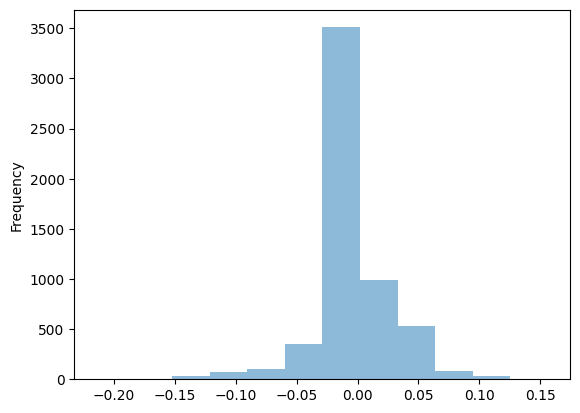

In [6]:
labels_tb
labels_tb = labels_tb.dropna()
labels_tb.pnls.plot.hist(bins=12, alpha=0.5)
labels_tb.pnls.describe()